# Coding up our own CNN

## What you are going to do

In this exercise, you will create algorithms to train non-linear models like CNNs.

In all of the tasks below, you should use PyTorch and PyTorch Lightning to design, train and test your CNN models. You can use matplotlib, pandas and numpy to visualize and study your results.

<div class="alert alert-block alert-warning">
    


### Import required libraries and packages

In [2]:
# If you run on Jupyter Lab uncomment bellow comment
#! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics"

# If you run on google colab uncomment bellow comment
# !pip install "pytorch-lightning" "torchmetrics"  -qq

# If you are running on your IDE (e.g VSCode) select the virtual environment that you have created as your python kernel

import os

import random

import matplotlib.colors as mpcol

import numpy as np # it's numpy, of course we need it!

import pandas as pd # for handling data

import matplotlib.pyplot as plt # for plotting

import torch # this is PyTorch
import torch.nn as nn # The torch.nn module contains the building blocks for our neural networks
from torch.nn import functional as F # functional is a subpackage that contains various different deep learning functions (e.g activation functions)
from torch import optim # is a package that implements various optimization algorithms used for training
from torch.utils.data.dataset import Dataset # We require the Dataset and DataLoader classes if we are handling custom data
from torch.utils.data import DataLoader, random_split

import torchmetrics # will need to install this separately, contains implementations for various metrics (e.g Accuracy)
import torchvision # will need to install this separately, consists popular datasets, model architectures, and common image transformations for computer vision.

from torchmetrics import Accuracy
from torchvision import transforms

from pytorch_lightning import LightningModule, Trainer, seed_everything # PyTorch lightning is essentially an abstraction of vanilla PyTorch
                                                                        # This is an optional install/import, but from personal experience I find
                                                                        # coding neural networks with lightning much easier (we'll look at the details in the slides)

from pytorch_lightning.callbacks.progress import TQDMProgressBar # Progress bar that lets you know that something is actually happening
from pytorch_lightning.loggers import CSVLogger # Logging function to log information after every training epoch (e.g train accuracy)
from pytorch_lightning.callbacks import Callback, ModelCheckpoint # For saving and loading checkpoints. Callbacks allow you to call functions after every training epoch

from tqdm import tqdm

# For reproducability
seed_everything(1234, workers=True)

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu') 

Global seed set to 1234


In [3]:
print(device)
print(torch.cuda.is_available())

cuda:0
True


## Design a Deep CNN and use it to Classify FashionMNIST

In this section you will be training a Shallow CNN to classify images using the data file "Section1_data.npz", which is the Fashion-MNIST dataset that contains images and labels for training, validation and test purposes (The images are 28x28 grayscale images).

You will use PyTorch's inbuilt datasets class, and Pytorch and PyTorch Lightning's module class to construct a CNN in order to perform training and testing on the given datasets using stochastic gradient descent (SGD).

| Type of data | Access |
| --- | --- |
| Train data (inputs) | data['arr_0']  |
| Train data (labels)| data['arr_1'] |
| Validation data (inputs) | data['arr_2']  |
| Validation data (labels)| data['arr_3'] |
| Test data (inputs) | data['arr_4']  |
| Test data (labels)| data['arr_5'] |

### Creating a Pytorch dataset for FashionMNIST

In [4]:
class FashionMNIST(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None): # for simplicity we will just use an int to specify our train/test/val split - not the best design!
        # change with your own path
        data = np.load("Section1_data.npz") # make sure to upload the STL10.npz file to your working directory!
        if trn_val_tst == 0:
            #trainloader
            self.images = data['arr_0'].T
            self.labels = data['arr_1']
        elif trn_val_tst == 1:
            #valloader
            self.images = ## YOUR CODE HERE ##
            self.labels = ## YOUR CODE HERE ##
        else:
            #testloader
            self.images = ## YOUR CODE HERE ##
            self.labels = ## YOUR CODE HERE ##

        self.images =  np.asarray(self.images).reshape(-1, 28, 28, 1).astype('float32') /255.0 # convert to float 32 for tensors, images are 28x28x1 grayscale
        self.transform = transform # REMEMBER IF WE WANT TO AUGMENT OUR DATA WE PASS THE TRANSFORMS TO THIS CLASS #

    def __len__(self):
        return len(self.labels) # length of labels = length of images

    def __getitem__(self, idx):
        if torch.is_tensor(idx): # idx will be a list of indexes as we will  be BATCHING
            idx = idx.tolist()

        sample = self.images[idx,:] # self.images is a two-dimensional array, the first dimension stores the image index and the second stores the image pixel values
        labels = self.labels[idx]
        if self.transform:  ## If there is a transform, apply it here to your sample
            sample = self.transform(sample)
        return sample, labels

In [5]:
BATCH_SIZE = 128     # the batch size for training task 1
N_WORKERS = 0 # don't worry too much about this

# Data augmentations - make sure to transform to tensor!
transform = transforms.Compose([## YOUR CODE HERE ##
                                ])

# Create an instance of the FashionMNIST dataset for the training, validation and test set
# Remember we defined FashionMNIST(trn_val_tst = 0, transform=None), use ints 0-2 to define the train/val/test and make sure to pass in the transform
train_set = ## YOUR CODE HERE ##
val_set = ## YOUR CODE HERE ##
test_set = ## YOUR CODE HERE ##

# Now we need to pass the dataset to the Pytorch dataloader class along with some other arguments
# DataLoader(dataset = dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS), make sure to shuffle the train dataset!
trainloader = ## YOUR CODE HERE ##
valloader = ## YOUR CODE HERE ##
testloader = ## YOUR CODE HERE ##

### Creating a CNN Model

![image](network_architecture_hidden.JPG)

In [7]:
class CNN(nn.Module): # This is our main model
    def __init__(self, learning_rate=1e-4):
        super().__init__()

        self.learning_rate = learning_rate

        
        self.conv1 = ## YOUR CODE HERE ##

        self.conv2 = ## YOUR CODE HERE ##

        self.fc1 = ## YOUR CODE HERE ##

        self.out = ## YOUR CODE HERE ##

        # Define Max Pooling (Default stride = kernel size)
        self.maxpool = ## YOUR CODE HERE ##

    def forward(self, x):
        # conv 1
        x = ## YOUR CODE HERE ##

        # conv 2
        x = ## YOUR CODE HERE ##

        # flatten for linear layers
        x = x.view(x.shape[0],-1)

        # fc1
        x = ## YOUR CODE HERE ##

        # output
        out = ## YOUR CODE HERE ##
        # don't need softmax here since we'll use cross-entropy as our loss function
        return out

### Training our CNN Model

In [10]:
LEARNING_RATE = 1e-4

loss_function = nn.CrossEntropyLoss()

model = CNN(learning_rate=LEARNING_RATE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [12]:
# simple empty array to log the loss
loss_log = []

# Perform 10 epochs
for epoch in range(2):
    loop = tqdm(trainloader)
    for idx, (x_batch, y_batch) in enumerate(loop):
        # perform forward pass
        target_pred = ## YOUR CODE HERE ##

        # calc loss
        loss = ## YOUR CODE HERE ##

        # zero gradients from previous step to avoid adding gradients
        ## YOUR CODE HERE ##

        # calculate new gradients
        ## YOUR CODE HERE ##

        # perform gradient descent
        ## YOUR CODE HERE ##

        loss_log.append(loss.item())

print("Loss:", loss.item())

100%|██████████| 469/469 [00:12<00:00, 38.97it/s]

Loss: 2.2995433807373047


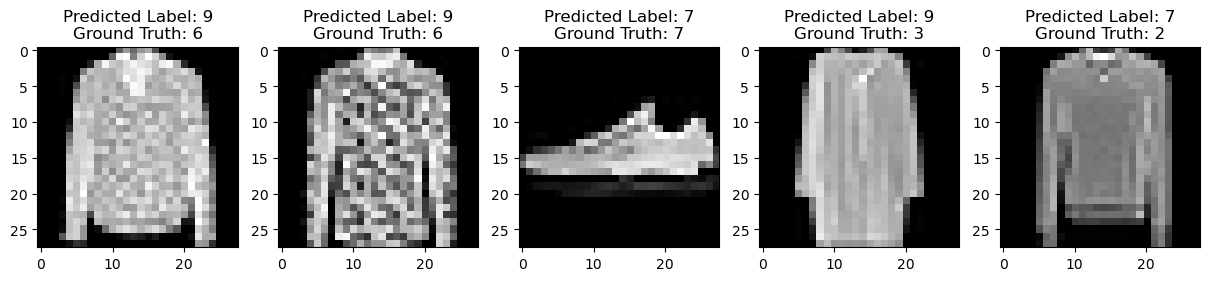

In [14]:
# Generate predictions using predict function
# Take a random test sample
test_data_iterator = iter(testloader)
data, labels = next(test_data_iterator)

predicted_labels = model(data).argmax(1)

data = data.reshape(BATCH_SIZE,28,28) # input data is not in 28x28 format -> for visualisation

input_im = data[0:5] # get first 5 images
ground_truth = labels[0:5] # get labels corresponding to first 5 images
predicted = predicted_labels[0:5] # get predictions corresponding to first 5 images

plt.figure(figsize=(15,8))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(input_im[i], cmap = "gray")
  plt.title(f'Predicted Label: {predicted[i]}\nGround Truth: {ground_truth[i]}')
